### Imports

In [1]:
import pandas as pd
import seaborn as sns
import sys
import glob
import pathlib
from oak_cli.utils.logging import logger
from icecream import ic

from oak_cli.evaluation.graph_utils import PALETTE, ROUNDING_PRECISION
from oak_cli.evaluation.addons.flops.graph_utils.keys import (
    RUN_ID_KEY,
    CPU_KEY,
    DISK_LAST_KEY,
    DISK_START_KEY,
    MEMORY_KEY,
    NETWORK_LAST_KEYS,
    NETWORK_START_KEYS,
    STAGE_KEY,
    TIME_START_KEY,
    ACCURACY_KEY,
    LOSS_KEY,
)
from oak_cli.evaluation.addons.flops.graph_utils.main import draw_graph, STAGE_ID_KEY, normalize_df_time_ranges
from oak_cli.evaluation.addons.flops.graph_utils.special_graphs import (
    draw_box_violin_plot_for_each_stage,
    draw_line_graph_with_all_runs,
    draw_trained_model_comparison_graph,
)
from oak_cli.evaluation.addons.flops.main import EvaluationRunFLOpsProjectStage
from oak_cli.evaluation.addons.flops.graph_utils.stages import STAGE_DURATIONS_KEY, get_stage_durations_df

### Settings

In [2]:
VERBOSE = True

### Data Loading

In [3]:
#csv_dir = get_csv_dir_for_scenario(EvaluationScenario.FLOPS)
csv_dir = pathlib.Path("/home/alex/oakestra-cli/oak_cli/evaluation/addons/flops/csv/monolith_mnist_sklearn_small_without_baseimages")
#csv_dir = pathlib.Path("/home/alex/oakestra-cli/oak_cli/evaluation/addons/flops/csv/monolith_hierarchical_mnist_sklearn_small_without_baseimages")

csv_files = glob.glob(f'{csv_dir}/evaluation_run_*.csv')
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Add a numerical stage ID (instead of the string) for future numerical manipulations.
df[STAGE_ID_KEY]  =  df[STAGE_KEY].apply(lambda stage_name: EvaluationRunFLOpsProjectStage(stage_name).get_index())

#trained_model_df = pd.read_csv(TRAINED_MODEL_PERFORMANCE_CSV)
trained_model_df = pd.read_csv(csv_dir / "trained_models.csv")

# NOTE: The CSV "time-since-start" values are very precise, thus they differ (slightly) between Evaluation-Runs.
# This difference leads to issues when trying to plot them in an aggregated way.
# To fix this we cast the floats to ints instead. I.e. we are looking at whole seconds - which is fine for this concrete use-case.
df[[TIME_START_KEY]] = round(df[[TIME_START_KEY]].astype(int) / 60, ROUNDING_PRECISION)

df.set_index(TIME_START_KEY, inplace=True)

normalized_df = normalize_df_time_ranges(df)

singular_run_df = df[df[RUN_ID_KEY] == (df[RUN_ID_KEY].max() // 2)]

### Error Handing & Checking

In [4]:
if not csv_dir.exists():
    logger.error(f"{csv_dir} does not exist yet!")
    sys.exit(1)

### Auxiliary

In [5]:
if VERBOSE:
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

### Common Graph Styling

In [6]:
sns.set_style("whitegrid")

---

# Graphs Drawing

### CPU & Memory

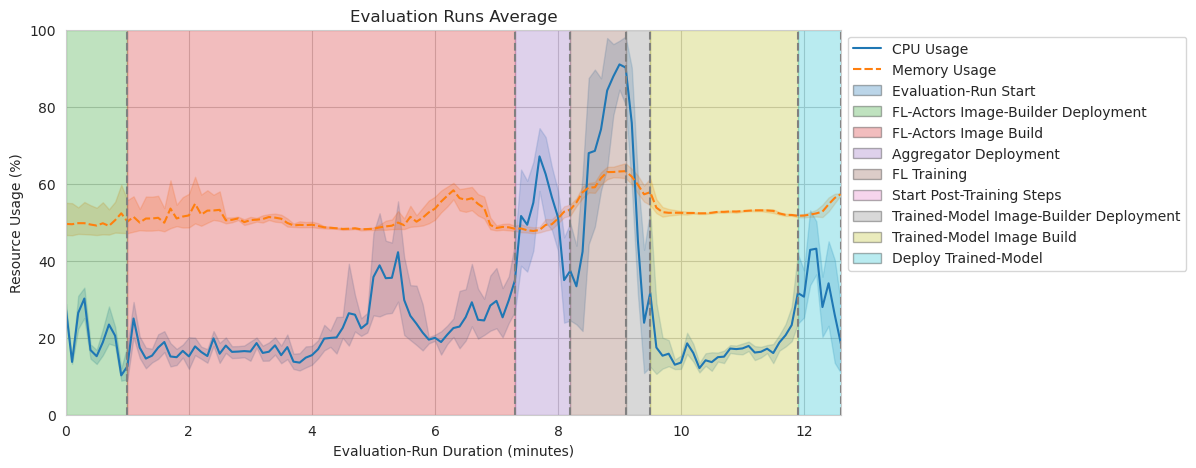

In [12]:
draw_graph(
    title="Evaluation Runs Average",
    data=normalized_df[[CPU_KEY, MEMORY_KEY, STAGE_KEY, RUN_ID_KEY]],
    plot_functions=[
        lambda: sns.lineplot(data=normalized_df[[CPU_KEY, MEMORY_KEY, STAGE_KEY]])
    ],
    use_percentage_limits=True,
    y_label="Resource Usage (%)",
    show_stages=True,
    use_median_stages=True,
)

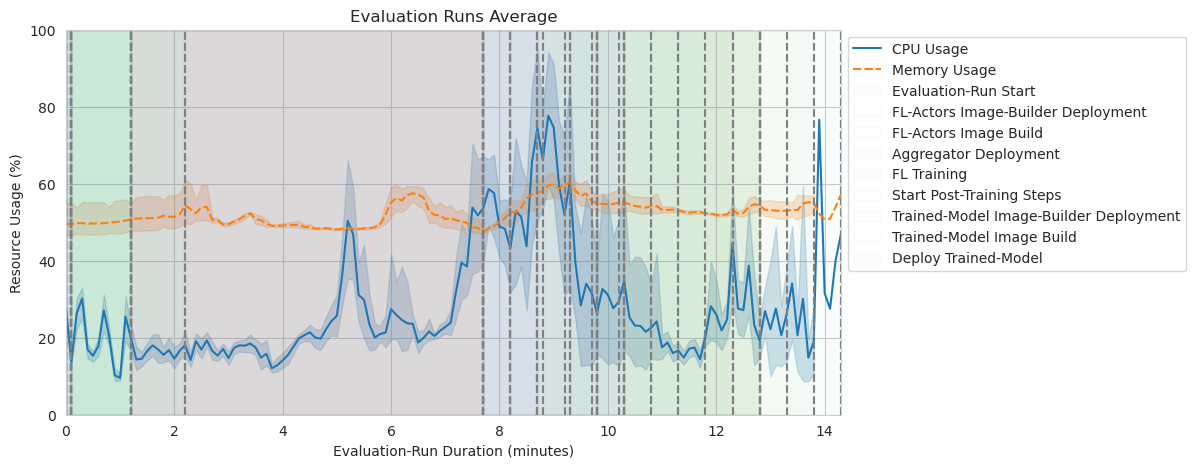

In [ ]:
draw_graph(
    title="Evaluation Runs Average",
    data=df[[CPU_KEY, MEMORY_KEY, STAGE_KEY]],
    use_percentage_limits=True,
    y_label="Resource Usage (%)",
    show_stages=True,
    stages_color_intensity=0.01,
)

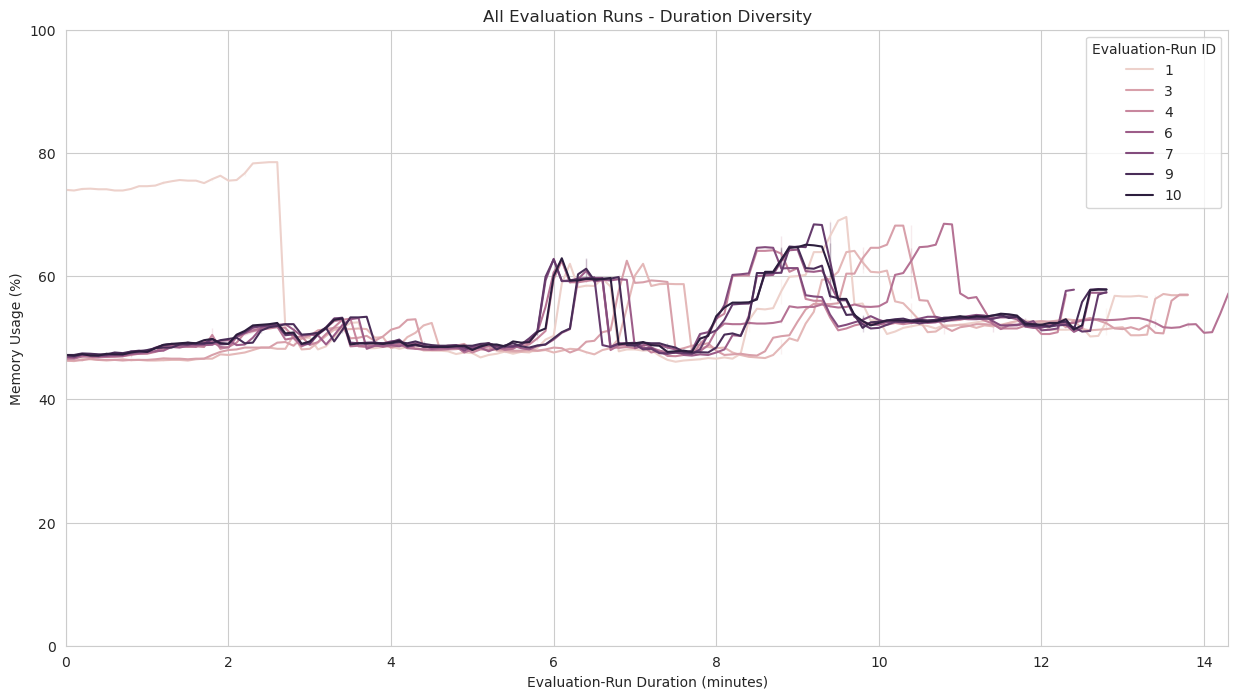

In [ ]:
draw_line_graph_with_all_runs(
    data=df,
    y_label="Memory Usage (%)",
    key=MEMORY_KEY,
    )

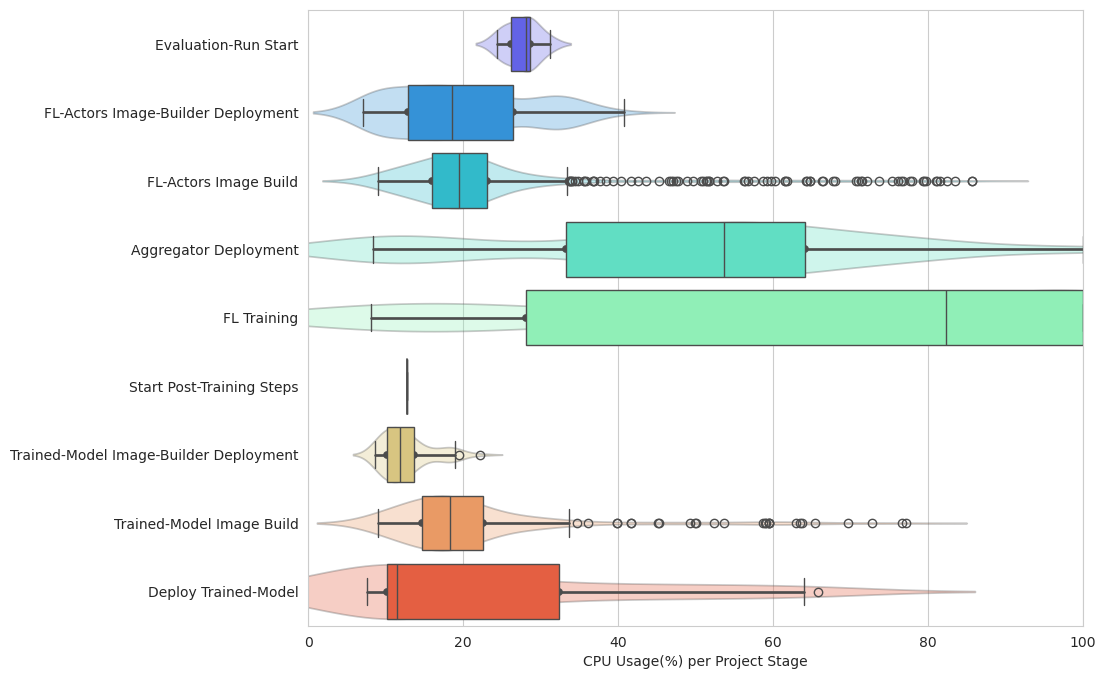

In [ ]:
draw_box_violin_plot_for_each_stage(
    data=df,
    key=CPU_KEY,
    x_label="CPU Usage(%) per Project Stage",
)

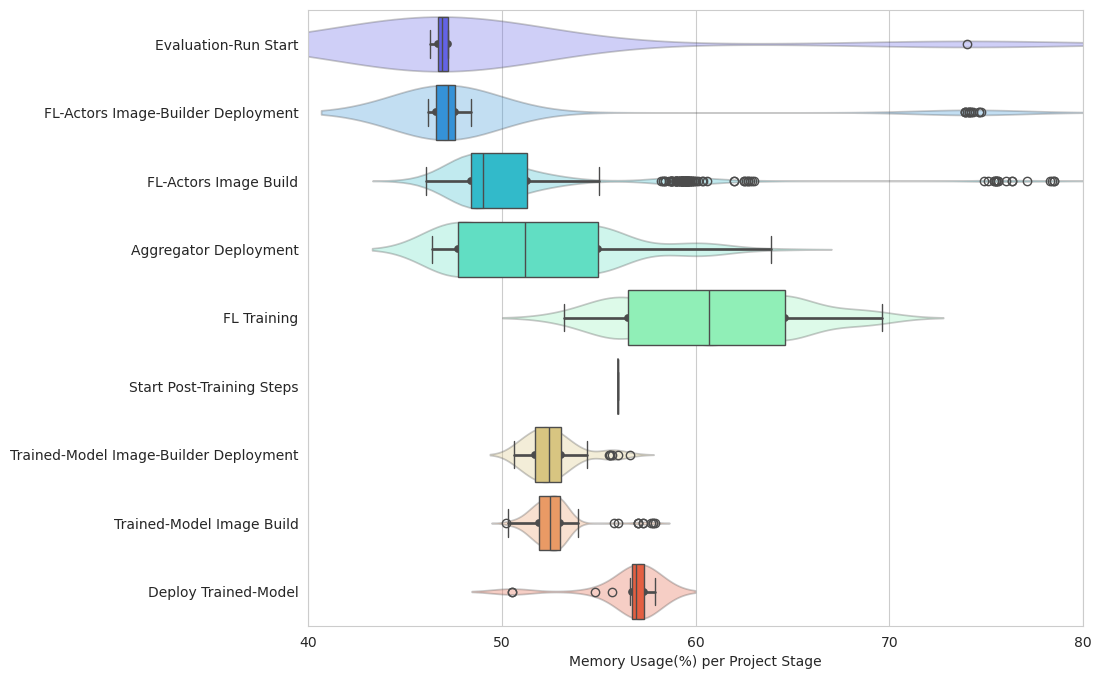

In [ ]:
draw_box_violin_plot_for_each_stage(
    data=df,
    key=MEMORY_KEY,
    x_label="Memory Usage(%) per Project Stage",
    x_lim=(40,80),
)

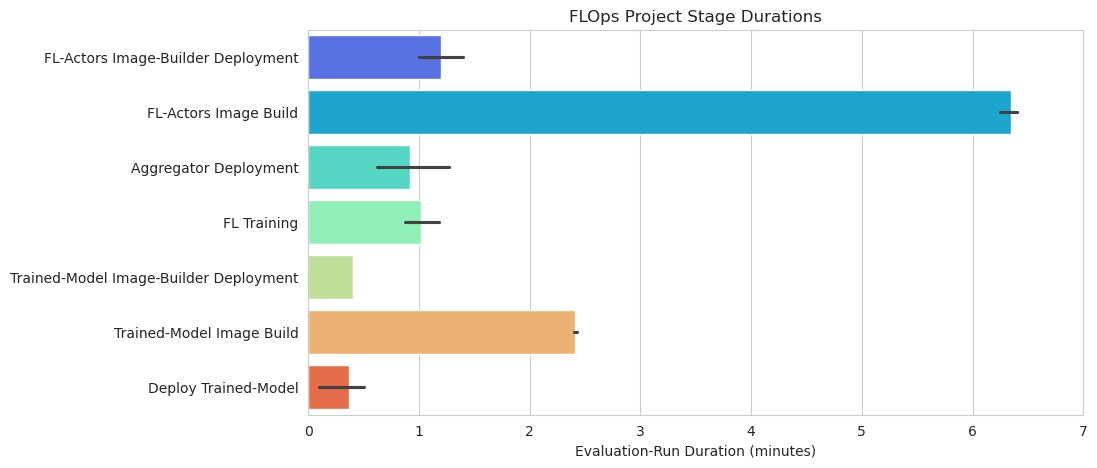

In [ ]:
_data = get_stage_durations_df(df)
draw_graph(
    data=_data,
    plot_functions=[
        lambda: sns.barplot(
            data=_data,
            x=STAGE_DURATIONS_KEY,
            y=STAGE_KEY,
            palette=PALETTE,
            hue=STAGE_KEY,
        )
    ],
    title="FLOps Project Stage Durations",
)


### Disk Space Changes

ValueError: The palette dictionary is missing keys: {'Disk Space Change Since Start'}

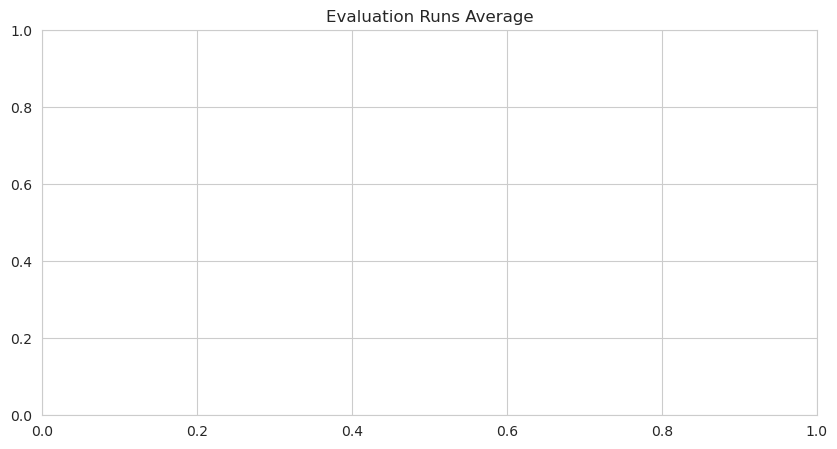

In [ ]:
_normalized_df = normalized_df.copy()
_normalized_df[[DISK_START_KEY]] = _normalized_df[[DISK_START_KEY]] / 1024

draw_graph(
    title="Evaluation Runs Average",
    data=_normalized_df[[DISK_START_KEY, STAGE_KEY, RUN_ID_KEY]],
    plot_functions=[
        lambda: sns.lineplot(data=_normalized_df[[DISK_START_KEY, STAGE_KEY]])
    ],
    y_label="Disk Space Change (GB)",
    x_lim=(0, max(_normalized_df.index)),
    y_lim=0,
    show_stages=True,
    use_median_stages=True,
)

In [ ]:
_test = singular_run_df.copy()

_test[["Disk MB/s"]] = round(_test[[DISK_LAST_KEY]] / 5, 1)
#_test[["Disk MB/s"]]

In [28]:

from typing import Tuple
ic(sns.color_palette("tab10", 10)[0])
#sns.color_palette(PALETTE, 10)

def get_color(index: int) -> Tuple[float, float, float]:
    return sns.color_palette("tab10", 10)[index]

ic| sns.color_palette("tab10", 10)[0]: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


In [31]:
# pallete_dict = {
#     EvaluationRunFLOpsProjectStage.EVALUATION_RUN_START: "black",
#     EvaluationRunFLOpsProjectStage.PROJECT_START: "blue",
#     EvaluationRunFLOpsProjectStage.FL_ACTORS_IMAGE_BUILDER_DEPLOYMENT: "green",
#     EvaluationRunFLOpsProjectStage.FL_ACTORS_IMAGE_BUILD: "red",
#     EvaluationRunFLOpsProjectStage.AGGREGATOR_DEPLOYMENT: "purple",
#     EvaluationRunFLOpsProjectStage.FL_TRAINING: "brown",
#     EvaluationRunFLOpsProjectStage.START_POST_TRAINING_STEPS: "pink",
#     EvaluationRunFLOpsProjectStage.TRAINED_MODEL_IMAGE_BUILDER_DEPLOYMENT: "grey",
#     EvaluationRunFLOpsProjectStage.TRAINED_MODEL_IMAGE_BUILD: "yellow",
#     EvaluationRunFLOpsProjectStage.DEPLOY_TRAINED_MODEL: "blue",
# }

my_dict = {}
for stage_enum in EvaluationRunFLOpsProjectStage:
    my_dict[stage_enum] = get_color(stage_enum.get_index())

ic(my_dict)

ic| my_dict: {<EvaluationRunFLOpsProjectStage.FL_ACTORS_IMAGE_BUILD: 'FL-Actors Image Build'>: (0.8392156862745098,
                                                                                                0.15294117647058825,
                                                                                                0.1568627450980392),
              <EvaluationRunFLOpsProjectStage.FL_ACTORS_IMAGE_BUILDER_DEPLOYMENT: 'FL-Actors Image-Builder Deployment'>: (0.17254901960784313,
                                                                                                                          0.6274509803921569,
                                                                                                                          

0.17254901960784313),
              <EvaluationRunFLOpsProjectStage.AGGREGATOR_DEPLOYMENT: 'Aggregator Deployment'>: (0.5803921568627451,
                                                                                                0.403921568627451,
                                                                                                0.7411764705882353),
              <EvaluationRunFLOpsProjectStage.START_POST_TRAINING_STEPS: 'Start Post-Training Steps'>: (0.8901960784313725,
                                                                                                        0.4666666666666667,
                                                                                                        0.7607843137254902),
              <EvaluationRunFLOpsProjectStage.FL_TRAINING: 'FL Training'>: (0.5490196078431373,
                                                                            0.33725490196078434,
                                                                

{<EvaluationRunFLOpsProjectStage.EVALUATION_RUN_START: 'Evaluation-Run Start'>: (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765),
 <EvaluationRunFLOpsProjectStage.PROJECT_START: 'Project Start'>: (1.0,
  0.4980392156862745,
  0.054901960784313725),
 <EvaluationRunFLOpsProjectStage.FL_ACTORS_IMAGE_BUILDER_DEPLOYMENT: 'FL-Actors Image-Builder Deployment'>: (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313),
 <EvaluationRunFLOpsProjectStage.FL_ACTORS_IMAGE_BUILD: 'FL-Actors Image Build'>: (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392),
 <EvaluationRunFLOpsProjectStage.AGGREGATOR_DEPLOYMENT: 'Aggregator Deployment'>: (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353),
 <EvaluationRunFLOpsProjectStage.FL_TRAINING: 'FL Training'>: (0.5490196078431373,
  0.33725490196078434,
  0.29411764705882354),
 <EvaluationRunFLOpsProjectStage.START_POST_TRAINING_STEPS: 'Start Post-Training Steps'>: (0.8901960784313725,
  0.4666666666666667,

ic| test_dict: {'0.0': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
                '1.0': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
                '10.0': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
                '11.0': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
                '12.0': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
                '13.0': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
                '14.0': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
                '2.0': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
                '3.0': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
                '4.0': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
                '5.0': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
                '6.0': (0.8392156862745098, 0.15

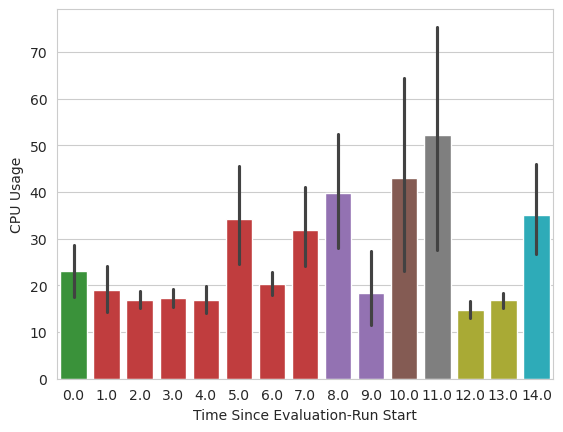

In [32]:
max_y = singular_run_df[DISK_LAST_KEY].max()
_test = singular_run_df.copy()
#_test[["Disk MB/s"]] = round(_test[[DISK_LAST_KEY]] / 5, 1)
_test[["Disk MB/s"]] = round(_test[[DISK_LAST_KEY]] / 5, 0)
# draw_graph(
#     size=(10,5),
#     title="Singular Example Evaluation Run",
#     #data=_test[["Disk MB/s", DISK_LAST_KEY, STAGE_KEY]],
#     data=_test[[CPU_KEY]],
#     plot_functions=[
#         lambda: sns.barplot(
#             #data=singular_run_df[[DISK_LAST_KEY, STAGE_KEY]],
#             #data=_test[["Disk MB/s"]],
#             # x=TIME_START_KEY,
#             data=_test[[CPU_KEY]],
#             x=TIME_START_KEY,
#             y=CPU_KEY
#             #y="Disk MB/s",
#         )
#     ],
#     y_label="Disk Space Change Between Measurements (MB)",
#     x_lim=(0, max(singular_run_df.index)),
#     # show_stages=True,
#     # stages_color_height=max_y,
#     #y_lim=(0, max_y)
#     #y_lim=(-1000, 1000)
# )

def myround(number: float) -> float:
    t = (number * 10) % 10
    if t == 0:
        return number
    if t <= 2 or t >= 8:
        return round(number)
    return (number * 10 - t + 5) / 10



_test.reset_index(inplace=True)
#ic(_test[[TIME_START_KEY]])
#_test[[TIME_START_KEY]] = _test[(_test[TIME_START_KEY]*10) % 5 == 0 ]

# _test[[TIME_START_KEY]] = _test[[TIME_START_KEY]].apply(
#         lambda time: myround(time)
#     )
_test[TIME_START_KEY] = _test[TIME_START_KEY].apply(myround)
#_test[TIME_START_KEY] = round(_test[TIME_START_KEY])
#_test[TIME_START_KEY] = myround(_test[TIME_START_KEY])
#_test[[TIME_START_KEY]] = myround(_test[[TIME_START_KEY]])
#ic(_test[[TIME_START_KEY]])
_test = _test[[TIME_START_KEY, CPU_KEY, STAGE_KEY]]
#_test[[TIME_START_KEY]] = pd.to_datetime(_test[[TIME_START_KEY]])
#_test = _test.groupby(pd.Grouper(key=TIME_START_KEY, freq="30s")).mean()
_test.set_index(TIME_START_KEY, inplace=True)
# sns.barplot(
#     #data=singular_run_df[[DISK_LAST_KEY, STAGE_KEY]],
#     #data=_test[["Disk MB/s"]],
#     # x=TIME_START_KEY,
#     data=_test[[CPU_KEY]],
#     x=TIME_START_KEY,
#     y=CPU_KEY
#     #y="Disk MB/s",
# )

# pallete_dict = {
#     EvaluationRunFLOpsProjectStage.EVALUATION_RUN_START: "black",
#     EvaluationRunFLOpsProjectStage.PROJECT_START: "blue",
#     EvaluationRunFLOpsProjectStage.FL_ACTORS_IMAGE_BUILDER_DEPLOYMENT: "green",
#     EvaluationRunFLOpsProjectStage.FL_ACTORS_IMAGE_BUILD: "red",
#     EvaluationRunFLOpsProjectStage.AGGREGATOR_DEPLOYMENT: "purple",
#     EvaluationRunFLOpsProjectStage.FL_TRAINING: "brown",
#     EvaluationRunFLOpsProjectStage.START_POST_TRAINING_STEPS: "pink",
#     EvaluationRunFLOpsProjectStage.TRAINED_MODEL_IMAGE_BUILDER_DEPLOYMENT: "grey",
#     EvaluationRunFLOpsProjectStage.TRAINED_MODEL_IMAGE_BUILD: "yellow",
#     EvaluationRunFLOpsProjectStage.DEPLOY_TRAINED_MODEL: "blue",
# }

# draw_graph(
#     size=(15,5),
#     title="Singular Example Evaluation Run",
#     #data=_test[["Disk MB/s", DISK_LAST_KEY, STAGE_KEY]],
#     data=_test[[CPU_KEY, STAGE_KEY]],
#     plot_functions=[
#         lambda: sns.barplot(
#             #data=singular_run_df[[DISK_LAST_KEY, STAGE_KEY]],
#             #data=_test[["Disk MB/s"]],
#             # x=TIME_START_KEY,
#             data=_test[[CPU_KEY, STAGE_KEY]],
#             x=TIME_START_KEY,
#             y=CPU_KEY,
#             #y="Disk MB/s",
#             #palette=PALETTE,
#             palette=pallete_dict,
#         )
#     ],
#     y_label="Disk Space Change Between Measurements (MB)",
#     #x_lim=(0, max(singular_run_df.index)),
#     #show_stages=True,
#     # stages_color_height=max_y,
#     #y_lim=(0, max_y)
#     #y_lim=(-1000, 1000)
# )

test_dict = {}
for i, row in _test.iterrows():
    color = my_dict[EvaluationRunFLOpsProjectStage(row[STAGE_KEY])]
    test_dict[str(i)] = color
    #ax.bar(i, row[CPU_KEY], color=color)

ic(test_dict)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.barplot(
    #data=singular_run_df[[DISK_LAST_KEY, STAGE_KEY]],
    #data=_test[["Disk MB/s"]],
    # x=TIME_START_KEY,
    data=_test[[CPU_KEY, STAGE_KEY]],
    x=TIME_START_KEY,
    y=CPU_KEY,
    #y="Disk MB/s",
    palette=test_dict,
    ax=ax,
)

plt.show()

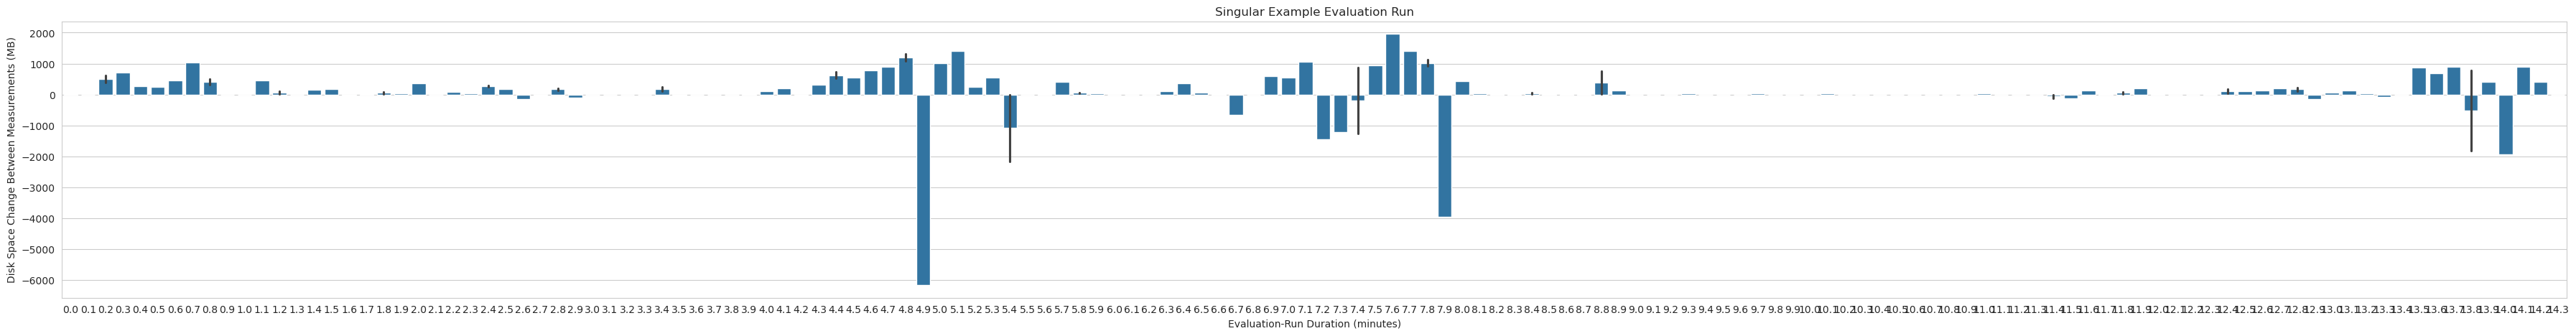

In [ ]:

max_y = singular_run_df[DISK_LAST_KEY].max()
draw_graph(
    size=(45,5),
    title="Singular Example Evaluation Run",
    data=singular_run_df[[DISK_LAST_KEY, STAGE_KEY]],
    plot_functions=[
        lambda: sns.barplot(
            #data=singular_run_df[[DISK_LAST_KEY, STAGE_KEY]],
            data=singular_run_df[[DISK_LAST_KEY]],
            x=TIME_START_KEY,
            y=DISK_LAST_KEY
        )
    ],
    y_label="Disk Space Change Between Measurements (MB)",
    #x_lim=(0, max(singular_run_df.index)),
    # show_stages=True,
    # stages_color_height=max_y,
    #y_lim=(0, max_y)
    #y_lim=(-1000, 1000)
)



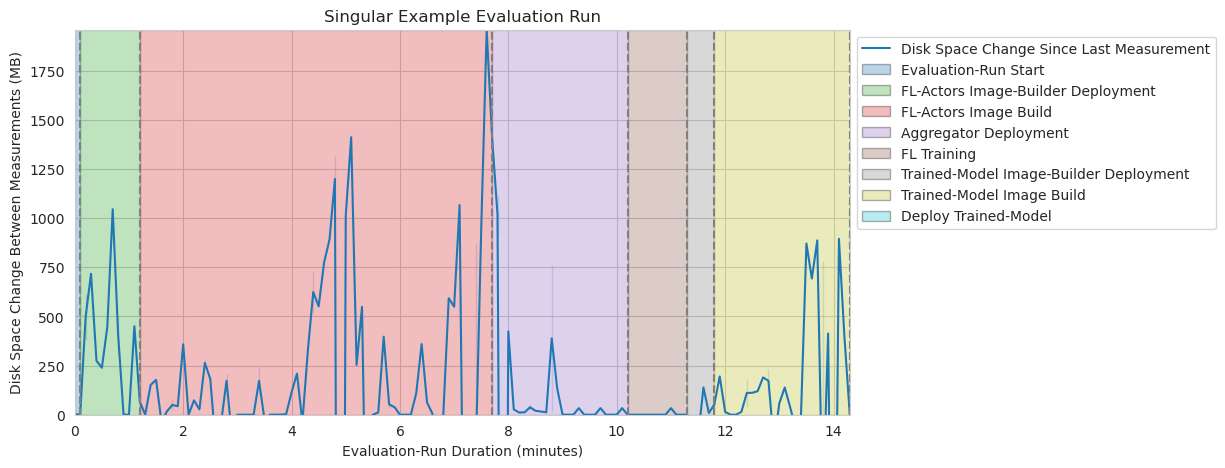

In [ ]:

max_y = singular_run_df[DISK_LAST_KEY].max()
draw_graph(
    title="Singular Example Evaluation Run",
    data=singular_run_df[[DISK_LAST_KEY, STAGE_KEY]],
    y_label="Disk Space Change Between Measurements (MB)",
    x_lim=(0, max(singular_run_df.index)),
    show_stages=True,
    stages_color_height=max_y,
    y_lim=(0, max_y)
)

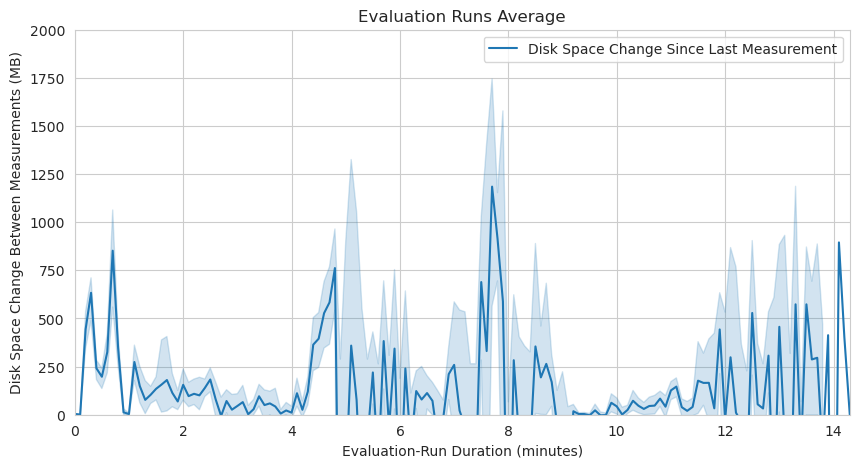

In [ ]:
max_y = df[DISK_LAST_KEY].max()
draw_graph(
    title="Evaluation Runs Average",
    data=df[[DISK_LAST_KEY, STAGE_KEY]],
    y_label="Disk Space Change Between Measurements (MB)",
    x_lim=(0, max(df.index)),
    #y_lim=(0, max_y),
    y_lim=(0, 2000),
    #show_stages=True,
    #stages_color_intensity=0.01,
)

### Network

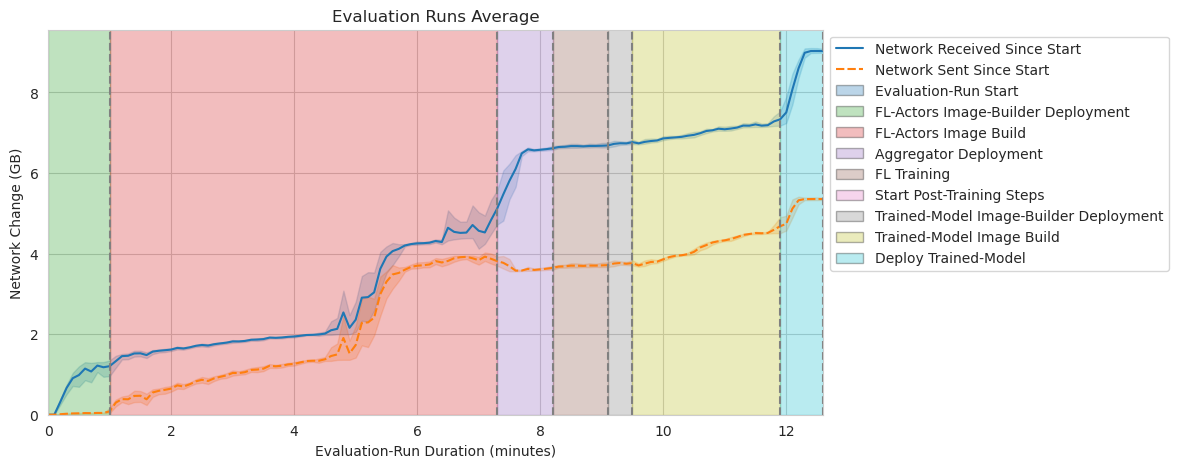

In [ ]:
_normalized_df = normalized_df.copy()
_normalized_df[NETWORK_START_KEYS] = _normalized_df[NETWORK_START_KEYS] / 1024

draw_graph(
    title="Evaluation Runs Average",
    data=_normalized_df[NETWORK_START_KEYS + [STAGE_KEY, RUN_ID_KEY]],
    plot_functions=[
        lambda: sns.lineplot(data=_normalized_df[NETWORK_START_KEYS + [STAGE_KEY]])
    ],
    y_label="Network Change (GB)",
    x_lim=(0, max(_normalized_df.index)),
    y_lim=0,
    show_stages=True,
    use_median_stages=True,
)

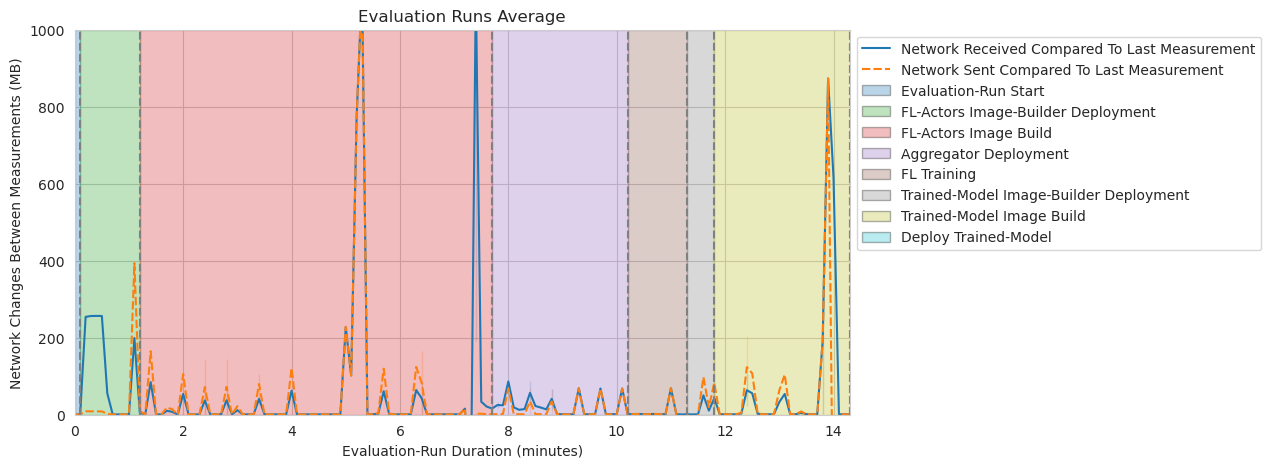

In [ ]:
draw_graph(
    title="Evaluation Runs Average",
    data=singular_run_df[NETWORK_LAST_KEYS + [STAGE_KEY]],
    y_label="Network Changes Between Measurements (MB)",
    x_lim=(0, max(singular_run_df.index)),
    y_lim=(0, 1000),
    show_stages=True,
    stages_color_height=1000
)

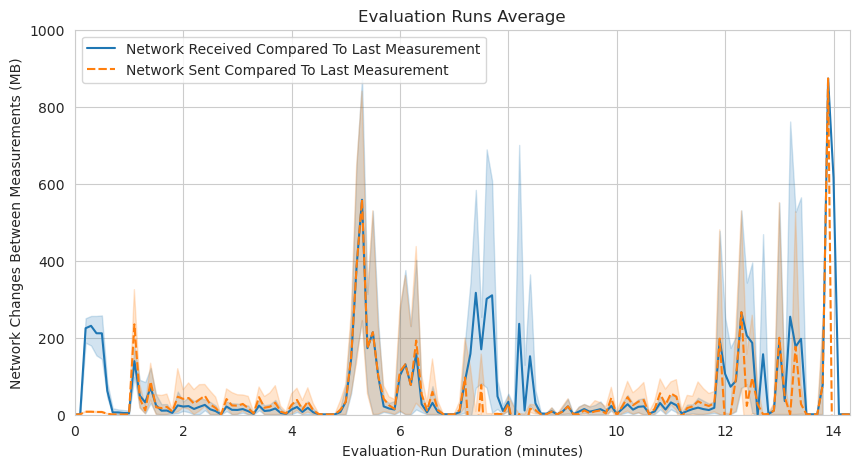

In [ ]:
draw_graph(
    title="Evaluation Runs Average",
    data=df[NETWORK_LAST_KEYS + [STAGE_KEY]],
    y_label="Network Changes Between Measurements (MB)",
    x_lim=(0, max(df.index)),
    y_lim=(0, 1000),
    #show_stages=True,
    #stages_color_intensity=0.01,
)

### Trained Models

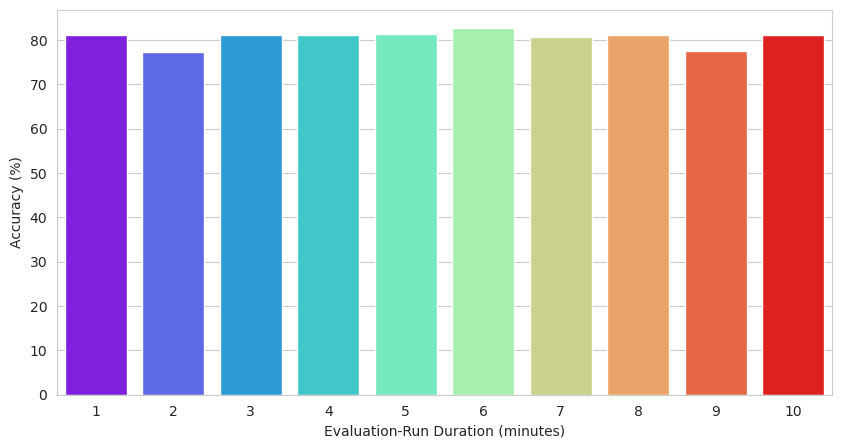

In [ ]:
draw_trained_model_comparison_graph(
    data=trained_model_df,
    key=ACCURACY_KEY,
    y_label="Accuracy (%)"
)

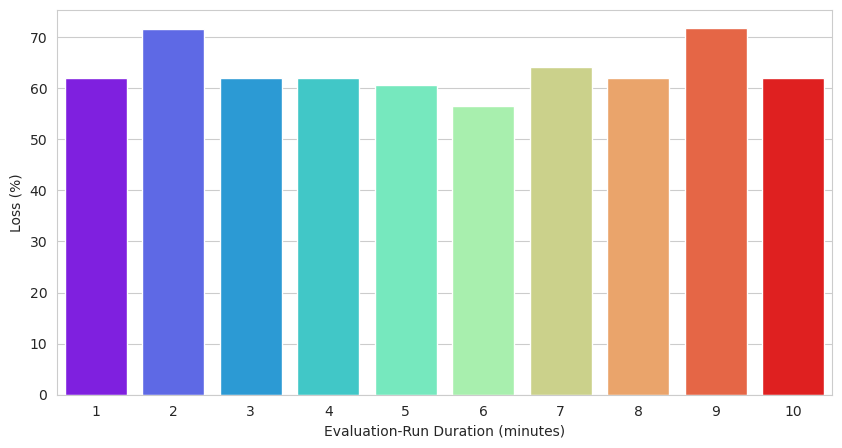

In [ ]:
draw_trained_model_comparison_graph(
    data=trained_model_df,
    key=LOSS_KEY,
    y_label="Loss (%)"
)